# 🧠 MNIST Neural Network Classifier with Keras
This notebook builds, trains, and evaluates a neural network on the MNIST handwritten digits dataset using Keras.
It includes comprehensive metrics, visualizations, and evaluation tools.

## 1. Install & Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.19.0
Keras version: 3.10.0


## 2. Load & Preprocess Data

In [2]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

# Flatten images: 28x28 -> 784
X_train_flat = X_train.reshape(-1, 784)
X_test_flat  = X_test.reshape(-1, 784)

print(f'Training samples : {X_train_flat.shape[0]}')
print(f'Test samples     : {X_test_flat.shape[0]}')
print(f'Input features   : {X_train_flat.shape[1]}')
print(f'Classes          : {np.unique(y_train)}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples : 60000
Test samples     : 10000
Input features   : 784
Classes          : [0 1 2 3 4 5 6 7 8 9]


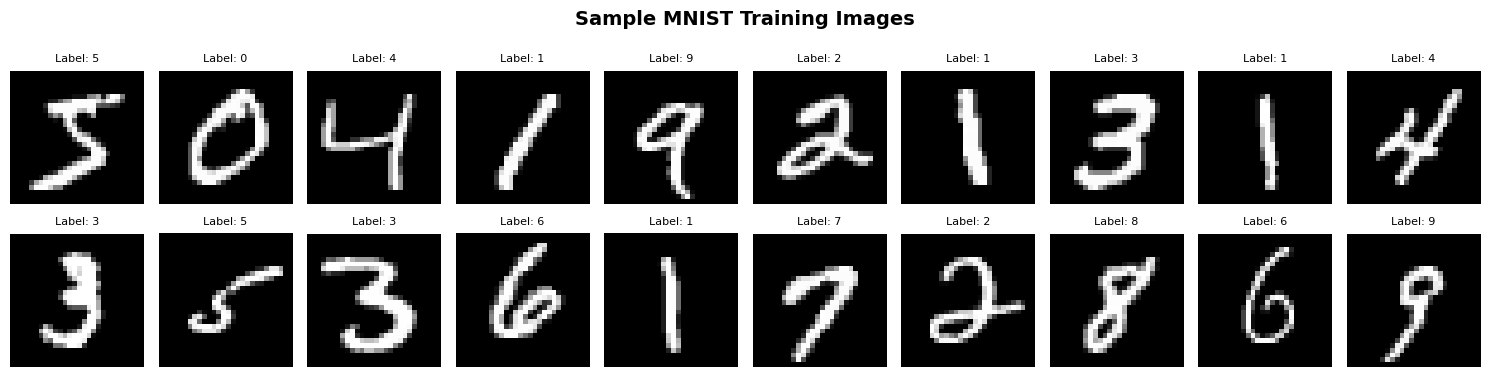

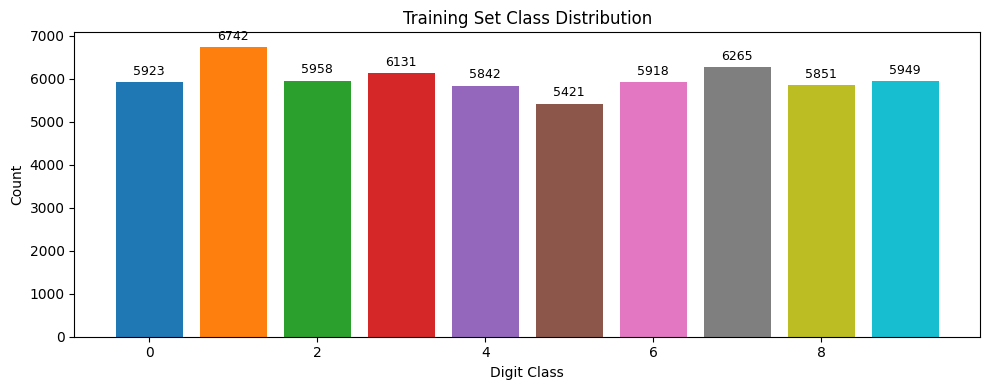

In [3]:
# Visualize sample digits
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}', fontsize=8)
    ax.axis('off')
plt.suptitle('Sample MNIST Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Class distribution
fig, ax = plt.subplots(figsize=(10, 4))
unique, counts = np.unique(y_train, return_counts=True)
bars = ax.bar(unique, counts, color=plt.cm.tab10.colors)
ax.set_xlabel('Digit Class')
ax.set_ylabel('Count')
ax.set_title('Training Set Class Distribution')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            str(count), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## 3. Build the Neural Network Model

In [4]:
def build_model(input_dim=784, num_classes=10):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        # Hidden Layer 1
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden Layer 2
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden Layer 3
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ], name='MNIST_Classifier')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')
        ]
    )
    return model

model = build_model()
model.summary()

Model: "MNIST_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,018 (2.18 MB)

 Trainable params: 569,226 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 4. Train the Model

In [5]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Train
history = model.fit(
    X_train_flat, y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8314 - loss: 0.5452 - top3_accuracy: 0.9377 - val_accuracy: 0.9717 - val_loss: 0.0966 - val_top3_accuracy: 0.9945 - learning_rate: 0.0010
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9537 - loss: 0.1561 - top3_accuracy: 0.9939 - val_accuracy: 0.9755 - val_loss: 0.0785 - val_top3_accuracy: 0.9967 - learning_rate: 0.0010
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9638 - loss: 0.1170 - top3_accuracy: 0.9960 - val_accuracy: 0.9780 - val_loss: 0.0788 - val_top3_accuracy: 0.9968 - learning_rate: 0.0010
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9712 - loss: 0.0886 - top3_accuracy: 0.9979 - val_accuracy: 0.9797 - val_loss: 0.0663 - val_top3_accuracy: 0.9967 - learning_rate: 0.0010
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9729 - loss: 0.0819 - top3_accuracy: 0.9982 - val_accuracy: 0.9812 - val_loss: 0.0631 - val_top3_accuracy: 0.

## 5. Training History & Learning Curves

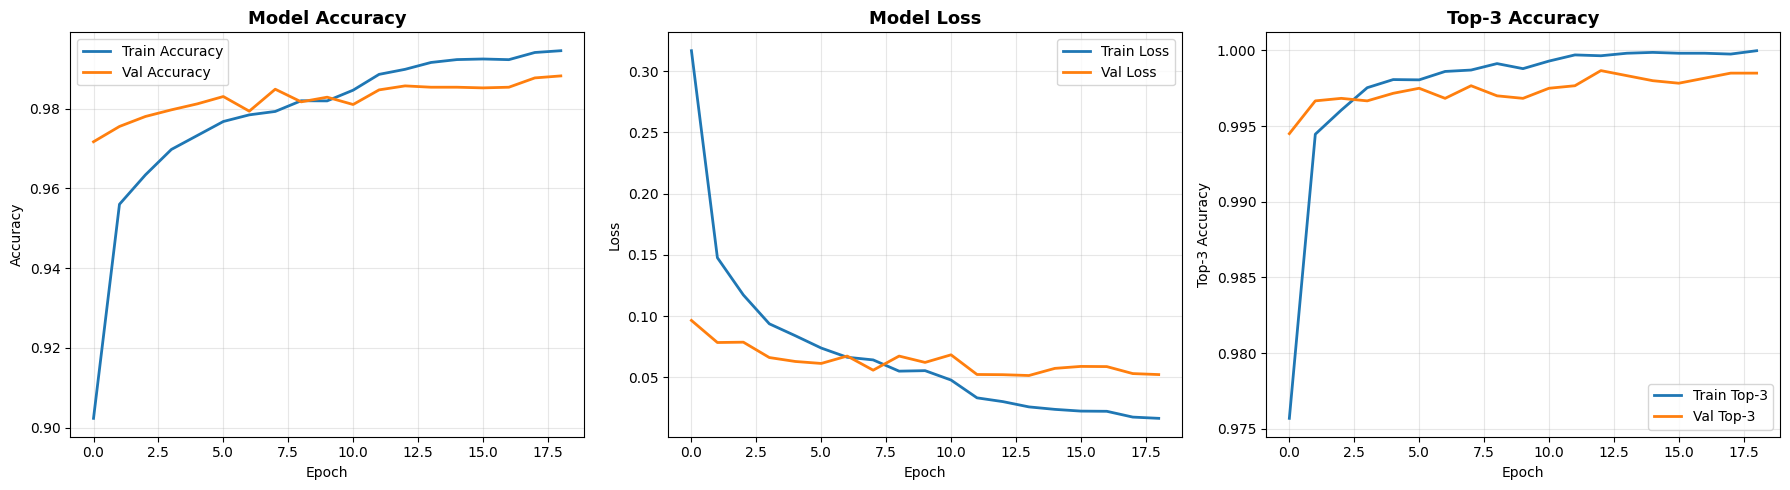

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Top-3 Accuracy
axes[2].plot(history.history['top3_accuracy'], label='Train Top-3', linewidth=2)
axes[2].plot(history.history['val_top3_accuracy'], label='Val Top-3', linewidth=2)
axes[2].set_title('Top-3 Accuracy', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Top-3 Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Evaluation on Test Set

In [7]:
# Evaluate
test_loss, test_acc, test_top3 = model.evaluate(X_test_flat, y_test, verbose=0)

print('=' * 45)
print('           TEST SET EVALUATION')
print('=' * 45)
print(f'  Test Loss        : {test_loss:.4f}')
print(f'  Test Accuracy    : {test_acc * 100:.2f}%')
print(f'  Top-3 Accuracy   : {test_top3 * 100:.2f}%')
print(f'  Error Rate       : {(1 - test_acc) * 100:.2f}%')
print('=' * 45)

# Predictions
y_pred_prob = model.predict(X_test_flat, verbose=0)
y_pred      = np.argmax(y_pred_prob, axis=1)

           TEST SET EVALUATION
  Test Loss        : 0.0524
  Test Accuracy    : 98.55%
  Top-3 Accuracy   : 99.93%
  Error Rate       : 1.45%


## 7. Confusion Matrix

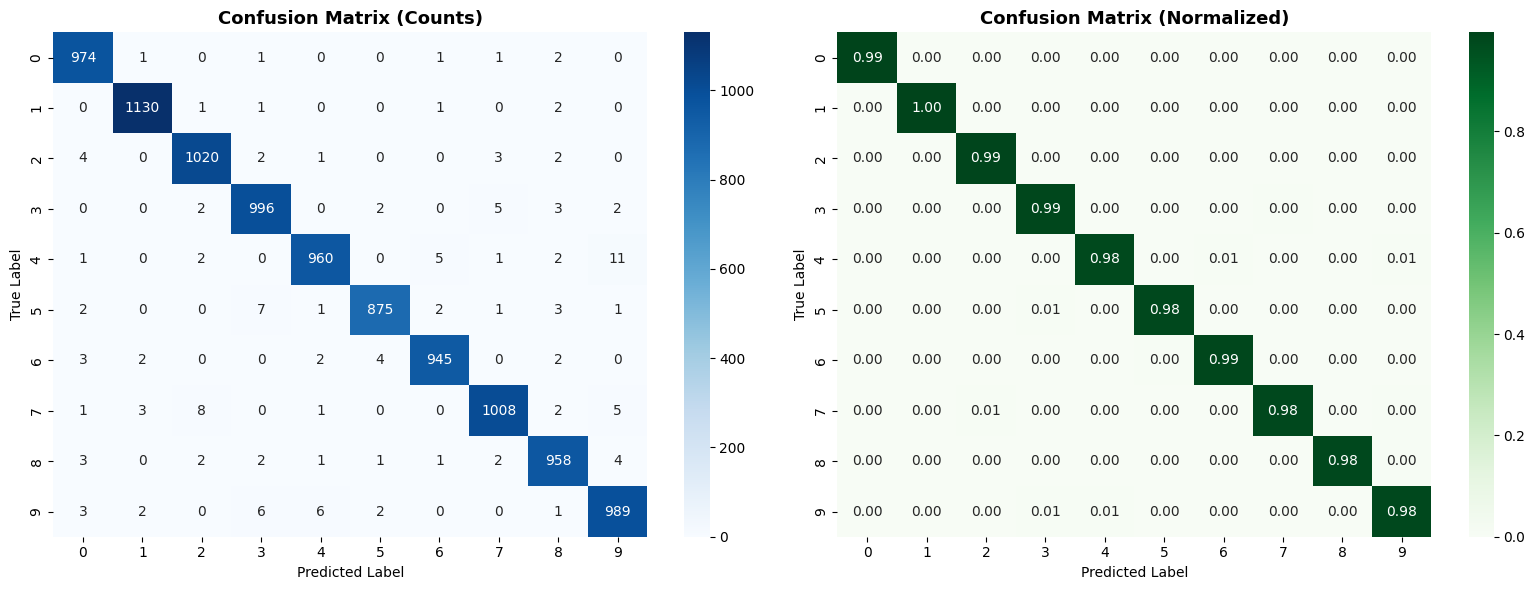

In [8]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=range(10), yticklabels=range(10))
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=range(10), yticklabels=range(10))
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

## 8. Classification Report

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



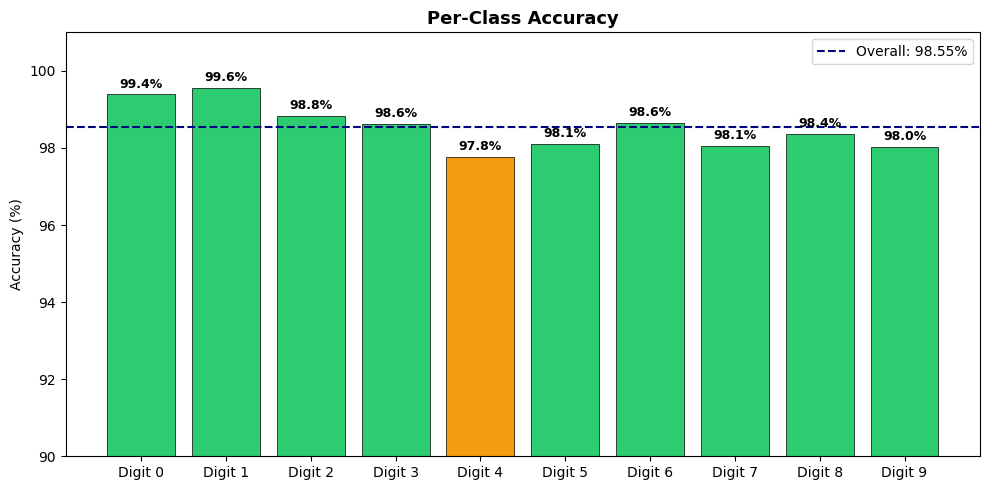

In [9]:
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)])
print('Classification Report:')
print(report)

# Per-class accuracy bar chart
per_class_acc = cm_norm.diagonal()
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if a >= 0.98 else '#f39c12' if a >= 0.95 else '#e74c3c' for a in per_class_acc]
bars = ax.bar(range(10), per_class_acc * 100, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(10))
ax.set_xticklabels([f'Digit {i}' for i in range(10)])
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
ax.set_ylim(90, 101)
ax.axhline(y=test_acc * 100, color='navy', linestyle='--', linewidth=1.5, label=f'Overall: {test_acc*100:.2f}%')
ax.legend()
for bar, acc in zip(bars, per_class_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. ROC Curves (One-vs-Rest)

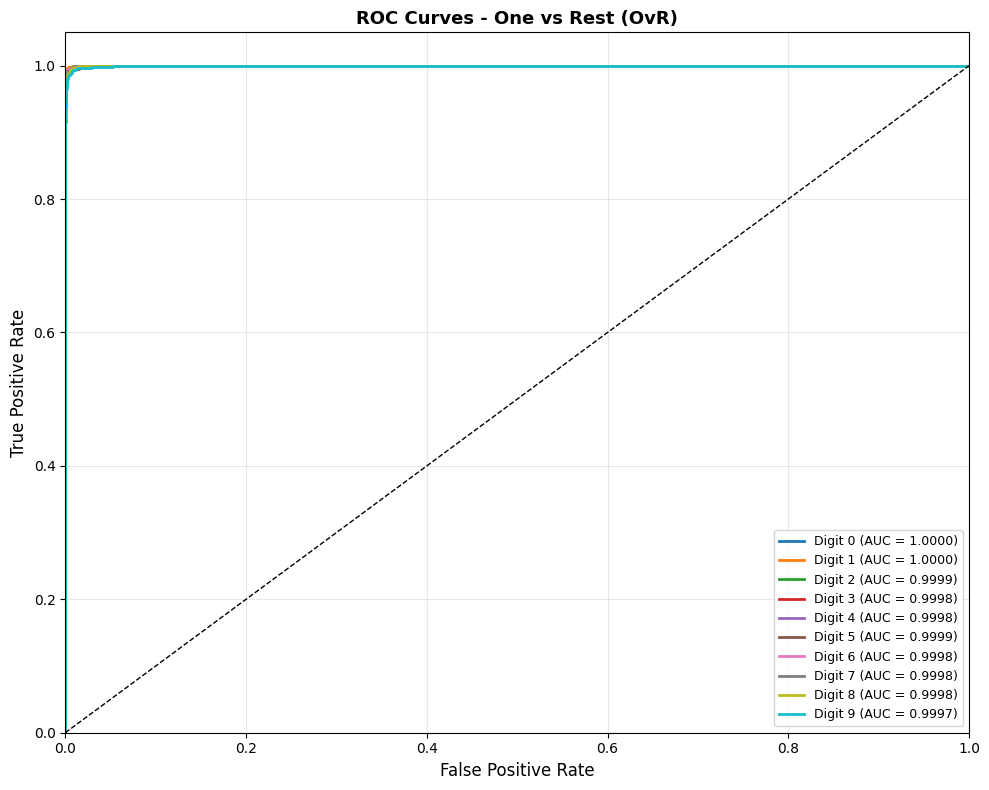

In [10]:
y_test_bin = label_binarize(y_test, classes=range(10))

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab10.colors

for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[i], lw=2, label=f'Digit {i} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - One vs Rest (OvR)', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Confidence Distribution & Calibration

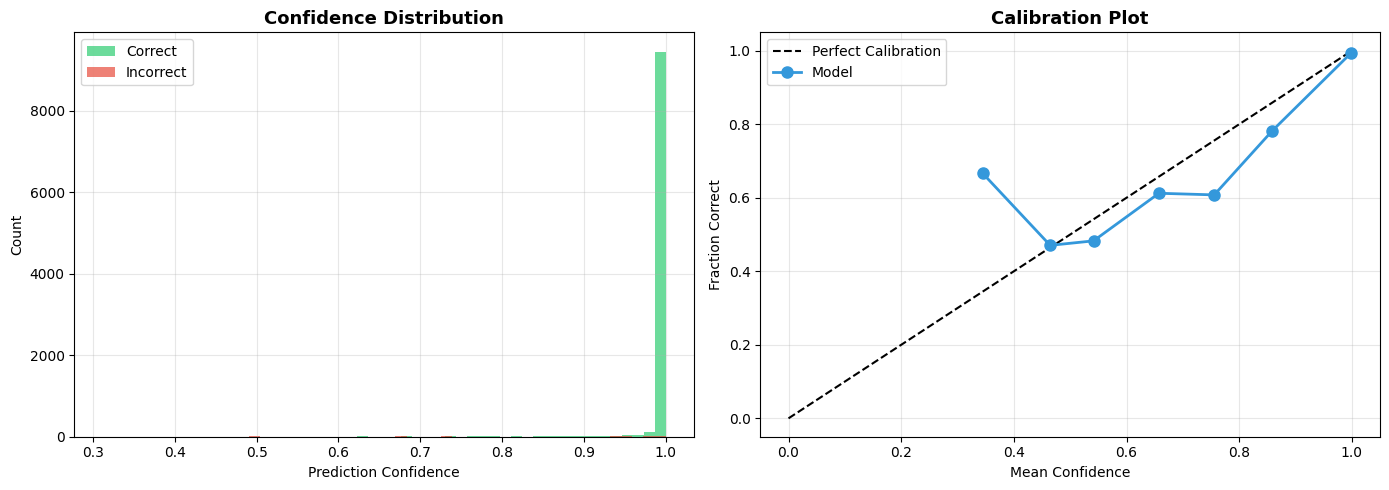

Mean confidence (correct)   : 0.9947
Mean confidence (incorrect) : 0.8025


In [11]:
max_confidences = np.max(y_pred_prob, axis=1)
correct = (y_pred == y_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence histogram
axes[0].hist(max_confidences[correct], bins=50, alpha=0.7, color='#2ecc71', label='Correct')
axes[0].hist(max_confidences[~correct], bins=50, alpha=0.7, color='#e74c3c', label='Incorrect')
axes[0].set_xlabel('Prediction Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Confidence Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Calibration plot
bins = np.linspace(0, 1, 11)
bin_accs, bin_confs = [], []
for lo, hi in zip(bins[:-1], bins[1:]):
    mask = (max_confidences >= lo) & (max_confidences < hi)
    if mask.sum() > 0:
        bin_accs.append(correct[mask].mean())
        bin_confs.append(max_confidences[mask].mean())
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1].plot(bin_confs, bin_accs, 'o-', color='#3498db', linewidth=2, markersize=8, label='Model')
axes[1].set_xlabel('Mean Confidence')
axes[1].set_ylabel('Fraction Correct')
axes[1].set_title('Calibration Plot', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Mean confidence (correct)   : {max_confidences[correct].mean():.4f}')
print(f'Mean confidence (incorrect) : {max_confidences[~correct].mean():.4f}')

## 11. Misclassified Samples

Total misclassified: 145 / 10000 (1.45%)


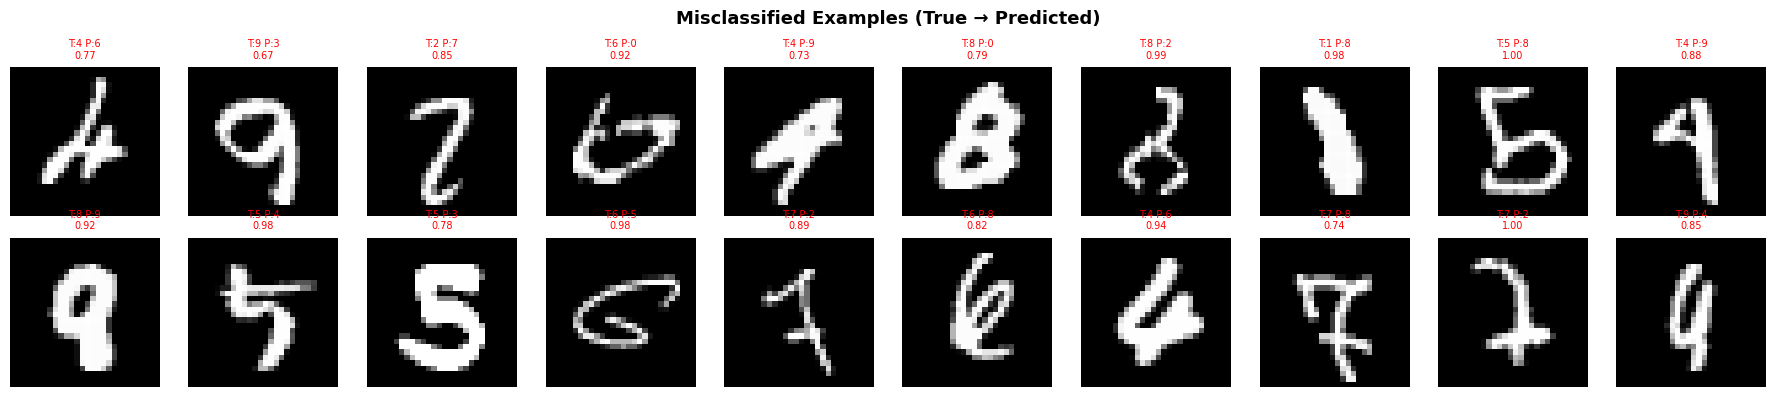

In [12]:
wrong_idx = np.where(y_pred != y_test)[0]
print(f'Total misclassified: {len(wrong_idx)} / {len(y_test)} ({len(wrong_idx)/len(y_test)*100:.2f}%)')

# Show 20 misclassified examples
sample = wrong_idx[:20]
fig, axes = plt.subplots(2, 10, figsize=(18, 4))
for ax, idx in zip(axes.flat, sample):
    ax.imshow(X_test[idx], cmap='gray')
    conf = max_confidences[idx]
    ax.set_title(f'T:{y_test[idx]} P:{y_pred[idx]}\n{conf:.2f}', fontsize=7, color='red')
    ax.axis('off')
plt.suptitle('Misclassified Examples (True → Predicted)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Summary Dashboard

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

precision = precision_score(y_test, y_pred, average='macro')
recall    = recall_score(y_test, y_pred, average='macro')
f1        = f1_score(y_test, y_pred, average='macro')
mcc       = matthews_corrcoef(y_test, y_pred)
mean_auc  = np.mean([auc(*roc_curve(label_binarize(y_test, classes=range(10))[:, i], y_pred_prob[:, i])[:2]) for i in range(10)])

metrics = {
    'Test Accuracy'    : f'{test_acc*100:.2f}%',
    'Test Loss'        : f'{test_loss:.4f}',
    'Top-3 Accuracy'   : f'{test_top3*100:.2f}%',
    'Macro Precision'  : f'{precision:.4f}',
    'Macro Recall'     : f'{recall:.4f}',
    'Macro F1 Score'   : f'{f1:.4f}',
    'Matthews CC'      : f'{mcc:.4f}',
    'Mean ROC-AUC'     : f'{mean_auc:.4f}',
    'Error Rate'       : f'{(1-test_acc)*100:.2f}%',
    'Misclassified'    : f'{len(wrong_idx):,} / {len(y_test):,}',
}

print('\n' + '='*50)
print('        FINAL MODEL PERFORMANCE SUMMARY')
print('='*50)
for k, v in metrics.items():
    print(f'  {k:<20}: {v}')
print('='*50)


        FINAL MODEL PERFORMANCE SUMMARY
  Test Accuracy       : 98.55%
  Test Loss           : 0.0524
  Top-3 Accuracy      : 99.93%
  Macro Precision     : 0.9855
  Macro Recall        : 0.9853
  Macro F1 Score      : 0.9854
  Matthews CC         : 0.9839
  Mean ROC-AUC        : 0.9998
  Error Rate          : 1.45%
  Misclassified       : 145 / 10,000
